# Defining the tennis game

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def tennis_game(p):
    M = np.array([
    [0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (0, 0) - 0
    [0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (15, 0) - 1
    [0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (0, 15) - 2
    [0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (30, 0) - 3
    [0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0], # (15, 15) - 4
    [0, 0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0], # (0, 30) - 5
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1-p, 0, p, 0, 0, 0, 0], # (40, 0) - 6
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 0, 0, 1-p, 0, 0], # (30, 15) - 7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1-p, 0, 0, p, 0, 0], # (15, 30) - 8
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 0, 0, 0, 1-p], # (0, 40) - 9
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0], # (40, 15) - 10
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 1-p], # (15, 40) - 11
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], # (Win, 0) - 12
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p, 0, 0], # (40, 30) - 13
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p, 0], # (30, 30) - 14
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p], # (30, 40) - 15
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # (0, Win) - 16
    ])
    return M

def extract_canonical_components(M):
    D = np.diag(M)
    absorbing, transient = np.where(D==1)[0], np.where(D!=1)[0]
    I = M[absorbing, :][:, absorbing]
    Q = M[transient, :][:, transient]
    R = M[transient, :][:, absorbing]
    O = M[absorbing, :][:, transient]
    return I, Q, R, O, absorbing, transient


# Creating the player and evaluating their choice of breaks

The main player can have both negative and positive decay rates. A negative rate of decay indicates the the opposition gets fatigued quicker than the main player while a positive rate of decay indicates the main players get fatigued quicker.

In [8]:
TOTAL_LENGTH = 55 #total number of games in a match

def player_func(p, rate_of_decay, t):
    return  2*p / (1 + np.exp(rate_of_decay * t ))

def recovery_func(player, base_rec =0.2):
    # effectiveness = 1 - t/TOTAL_LENGTH
    # boost = base_rec * effectiveness
    # player.p = min(player.p*(1 + boost), player.init_p) # ensure p does not exceed initial value
    # player.time_since_last_recovery = t
    player.player_t *= base_rec

class Player:
    def __init__(self, p_func, recover_func, p, break_times, decay_rate):
        self.p_func = p_func
        self.recover_func = recover_func
        self.p = p
        self.time_since_last_recovery = 0
        self.rate_of_decay = decay_rate
        self.break_times = break_times
        self.player_t = 0 #This is related the calculating the player's performance over time
        self.t = 0 # This is the time in the match, which is used to determine when to recover

    def eval_p(self):
        if self.t in self.break_times:
            self.recover_func(self)
        self.t += 1
        self.player_t += 1
        return self.p_func(self.p, self.rate_of_decay, self.player_t)

    def __str__(self):
        return f"Player(p={self.p}, break_times={self.break_times})"
        

def eval_fitness(match_result):
    return len([1 for r in match_result if r == 1]) / len(match_result)


# Simulating a tennis match


Winner: 2


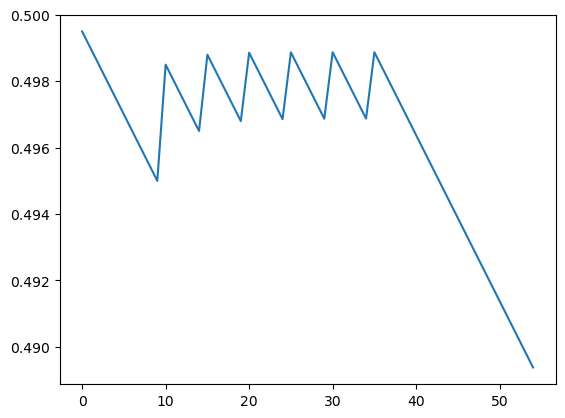

In [3]:
def simulate_game(M, max_iter=300):
    pos = [0]
    for i in range(max_iter):
        pos_next = np.random.choice(len(M), p=M[pos[-1]])
        if pos_next == pos[-1]:
            return pos + [pos_next] 
        else:
            pos += [pos_next]
    #Got stuck in a loop, game was not able to be resolved
    return 3

def simulate_set(p1):
    game_results = []
    p1_wins = 0
    p2_wins = 0
    t = 0
    p1_p_list = []
    while p1_wins < 6 and p2_wins < 6:
        game_result = simulate_game(tennis_game(p1.eval_p()))
        p1_p_list.append(p1.eval_p())
        if game_result == -1:
            print("Game could not be resolved.")
            return -1
        if game_result[-1] == 12:  # Player 1 wins
            p1_wins += 1
        elif game_result[-1] == 16:  # Player 2 wins
            p2_wins += 1
        game_results.append(1 if game_result[-1] == 12 else 2)
        t += 1
    res = [0, game_results]
    if p1_wins == 6:
        res[0] = 1
    elif p2_wins == 6:
        res[0] = 2
    else:
        print("Set could not be resolved.")
        res[0] = 3
    # print(f"Set result: {res[0]}, P1 wins: {p1_wins}, P2 wins: {p2_wins}")
    return res, p1_p_list
    
#The second player's chance of winning is 1 - p1's chance so we do not need to create it.
def simulate_match(p1, max_sets=5):
    sets = []
    set_results = []
    evolution_p = []
    for i in range(max_sets):
        [set_winner, set_result], p1_p_list = simulate_set(p1)
        evolution_p.extend(p1_p_list)
        if set_winner == 3:
            print(f"Set {i+1} could not be resolved.")
            break
        sets.append(set_winner)
        set_results.append([set_result])
    counts = np.bincount(sets)
    winner = np.argmax(counts) 

    return winner, sets, set_results, evolution_p
 

p1 = Player(player_func, recovery_func, 0.5, [20,30,50,40,60, 70], 0.001)
winner,_,_, evolution_p = simulate_match(p1)
print("Winner:", winner)
plt.plot(evolution_p)

# Monte Carlo simulation of several matches

In [4]:
def monte_carlo_matches(p1, reps, verbose=False, max_iter=100):
    ties = 0
    winners = []
    # final_transients = []
    # game_lengths = []
    for i in range(reps):
        if verbose: print('Simulating game {0}'.format(i))
        winner, match, match_results, evolution_p = simulate_match(p1)
        tie = (type(match) in [int])
        if verbose: print('Game was {0} a tie'.format((1-tie)*'not'))
        ties += tie 
        # if not tie:
        winners.append(winner)  
            # final_transients += [game[-3]]
            # if verbose: print('Winner was {0}, Second Last State was {1}'.format(winners[-1], final_transients))
    # game_lengths += [len(game)-2]
    winners = np.array(winners)
    # final_transients = np.array(final_transients)
    return winners

win = monte_carlo_matches(p1, 1000)
print(eval_fitness(win))


0.0


# Genetic algorithm

In [ ]:
def crossover(p1, p2):
    cross_times = np.unique(np.random.choice(p1.break_times, 3, replace=False) + np.random.choice(p2.break_times, 3, replace=False))
    while len(cross_times) < 6:
        cross_times = np.unique(np.concatenate([cross_times, np.random.choice(TOTAL_LENGTH, 6-len(cross_times), replace=False)]))
    #We are optimising over the same player, so its initial prob of winning should be the same. 
    return Player(player_func, recovery_func, p1.p, cross_times, p1.rate_of_decay)

def mutation(p1):
    break_to_mutate = np.random.randint(0, 5)
    inc = 1
    new_time = p1.break_times[break_to_mutate]
    while new_time in p1.break_times:
        # TODO need modulo and all that shit to handle break times
        new_time = break_to_mutate + (-1 * np.sign(inc))*(np.abs(inc) + 1)
        if inc < 0:
            inc -= 1
        inc *= -1
    p1.break_times[break_to_mutate] = new_time
    return Player(player_func, recovery_func, p1.p, p1.break_times, p1.rate_of_decay)

def genetic_algorithm(p, decay_rate, mut_p, cross_p, n_elite =1, population_size=10, generations=100, verbose=False):
    
    population = [Player(player_func, recovery_func, p, np.random.choice(range(TOTAL_LENGTH), 6, replace=False), decay_rate) for _ in range(population_size)]
    for i in range(generations):
        print(f'Generation {i+1}/{generations}')
        fitness_scores = np.array([])
        for player in population:
            winners = monte_carlo_matches(player, 100, verbose=False)
            print(player, winners)
            fitness_scores = np.append(fitness_scores, [eval_fitness(winners)])
        
        sorted_indices = np.argsort(fitness_scores)[::-1]
        next_generation = [Player(player_func, recovery_func, p, population[i].break_times, decay_rate) for i in sorted_indices[:n_elite]]
        
        print(fitness_scores)
        f_total = sum(fitness_scores)
        if f_total == 0: 
            print("All fitness scores are zero, cannot proceed with selection.")
            return None
        
        fitness_scores = fitness_scores / f_total
        
        while len(next_generation) < population_size:
            idx = np.random.choice(population_size, p=fitness_scores)
            new_player = population[idx]
            if np.random.rand() < cross_p:
                partner_idx = np.random.choice(population_size, p=fitness_scores)
                new_player = crossover(new_player, population[partner_idx])
            elif np.random.rand() < mut_p:
                new_player = mutation(new_player)
            # if verbose: print(f'Creating new player with break_times={new_player.break_times}')
            next_generation.append(new_player)
        if verbose: print('Best break times found so far {}. Fitness is {}'.format(population[sorted_indices[0]].break_times, fitness_scores[sorted_indices[0]]*f_total))
        population = next_generation

    best_player = population[np.argmax(fitness_scores)]
    print(f'Best player found with initial probability {best_player.p} and break times {best_player.break_times}')
    return best_player 
        
genetic_algorithm(0.55, 0.00005, 0.2, 0.3, n_elite=0, population_size=5, generations=10, verbose=True)

Generation 1/10
Player(p=0.55, break_times=[26 29 18 47  3 11]) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1
 1 2 2 1 2 2 2 1 2 2 2 2 1 2 1 2 1 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2]
Player(p=0.55, break_times=[45 43  0 38 11 20]) [1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 2 1 1 1 2 2 1 2 2 1 1 1
 2 1 2 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2]
Player(p=0.55, break_times=[52  7 53  2 49 44]) [1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 2 2 1 2 1
 1 2 1 1 1 2 2 1 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2]
Player(p=0.55, break_times=[42 28 10  2 35 51]) [1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 2 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2
 2 1 1 1 1 2 1 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2

KeyboardInterrupt: 

In [ ]:
def crossover(p1, p2):
    cross_times = np.unique(np.random.choice(p1.break_times, 3, replace=False) + np.random.choice(p2.break_times, 3, replace=False))
    while len(cross_times) < 6:
        cross_times = np.unique(np.concatenate([cross_times, np.random.choice(TOTAL_LENGTH, 6-len(cross_times), replace=False)]))
    #We are optimising over the same player, so its initial prob of winning should be the same. 
    return Player(player_func, recovery_func, p1.p, cross_times, p1.rate_of_decay)

def mutation(p1):
    break_to_mutate = np.random.randint(0, 5)
    inc = 1
    new_time = break_to_mutate
    while new_time in p1.break_times:
        # TODO need modulo and all that shit to handle break times
        new_time = break_to_mutate + (-1 * np.sign(inc))*(np.abs(inc) + 1)
        if inc < 0:
            inc -= 1
        inc *= 1
    p1.break_times[break_to_mutate] = new_time
    return Player(player_func, recovery_func, p1.p, p1.break_times, p1.rate_of_decay)

def genetic_algorithm(p, decay_rate, mut_p, cross_p, n_elite =1, population_size=10, generations=100, verbose=False):
    
    population = [Player(player_func, recovery_func, p, np.random.choice(range(TOTAL_LENGTH), 6, replace=False), decay_rate) for _ in range(population_size)]
    for i in range(generations):
        print(f'Generation {i+1}/{generations}')
        fitness_scores = np.array([])
        for player in population:
            winners = monte_carlo_matches(player, 100, verbose=False)
            print(player, winners)
            fitness_scores = np.append(fitness_scores, [eval_fitness(winners)])
        
        sorted_indices = np.argsort(fitness_scores)[::-1]
        next_generation = [Player(player_func, recovery_func, p, population[i].break_times, decay_rate) for i in sorted_indices[:n_elite]]
        
        print(fitness_scores)
        f_total = sum(fitness_scores)
        if f_total == 0: 
            print("All fitness scores are zero, cannot proceed with selection.")
            return None
        
        fitness_scores = fitness_scores / f_total
        
        while len(next_generation) < population_size:
            idx = np.random.choice(population_size, p=fitness_scores)
            new_player = population[idx]
            if np.random.rand() < cross_p:
                partner_idx = np.random.choice(population_size, p=fitness_scores)
                new_player = crossover(new_player, population[partner_idx])
            elif np.random.rand() < mut_p:
                new_player = mutation(new_player)
            # if verbose: print(f'Creating new player with break_times={new_player.break_times}')
            next_generation.append(new_player)
        if verbose: print('Best break times found so far {}. Fitness is {}'.format(population[sorted_indices[0]].break_times, fitness_scores[sorted_indices[0]]*f_total))
        population = next_generation

    best_player = population[np.argmax(fitness_scores)]
    print(f'Best player found with initial probability {best_player.p} and break times {best_player.break_times}')
    return best_player 
        
genetic_algorithm(0.55, 0.00005, 0.2, 0.3, n_elite=0, population_size=5, generations=10, verbose=True)

Generation 1/10
Player(p=0.55, break_times=[10 49  6 21 39 51]) [1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 2 2 1 1 1 1 1 2 2 1 2 2 1
 1 1 2 1 2 1 1 2 1 1 2 2 1 2 2 2 2 1 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Player(p=0.55, break_times=[37 34 11 49  6 13]) [1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 2
 1 2 2 1 1 1 1 1 1 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Player(p=0.55, break_times=[27 48 16 12 20 10]) [1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2 1 2 1 1 2 2
 1 1 1 2 2 1 2 2 2 2 2 2 1 1 2 2 2 2 1 2 2 2 2 1 1 1 1 2 1 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Player(p=0.55, break_times=[ 3 14 53 24 39 41]) [1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 2 2 1 1 2 1 1 1 2 1 2 1
 1 2 2 1 2 2 2 2 2 1 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2 1 2 1 1 2 1 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2